In [1]:
from CNNectome.validation.organelles.segmentation_metrics import Evaluator,EvaluationMetrics,display_name,sorting
import h5py
import numpy as np
import csv
import os
import matplotlib
%matplotlib inline 
from matplotlib import pyplot as plt
import pandas as pd
import re
import zarr
import tifffile
import seaborn
import pandas
from scipy.ndimage import label, distance_transform_edt
from CNNectome.utils.compute_label_distribution import distance


class Cropper:
    def __init__(self, mins, maxs):
        self.mins = tuple(mins)
        self.maxs = tuple(maxs)
    
    def crop(self, im, rescale_factor = 1):
        if rescale_factor != 1:
            im = im.repeat(rescale_factor, axis=0).repeat(rescale_factor, axis=1).repeat(rescale_factor, axis=2)
        im = im[self.mins[0]:self.maxs[0],self.mins[1]:self.maxs[1],self.mins[2]:self.maxs[2]]
        return im

class Row:
    def __init__(self, row):
        self.row = row

    def get(self, column):
        c = self.row[column]
        if "x" in c:
            return [int(c["z"]), int(c["y"]), int(c["x"])]
        elif "x min" in c:
            return [int(c["z min"]), int(c["y min"]), int(c["x min"])], [int(c["z max"]), int(c["y max"]), int(c["x max"])]
        else:
            # Way to treat it when  contains eg unnamed 0_level_0
            return c[c.keys()[0]]
 

/groups/scicompsoft/home/ackermand/miniconda3/envs/CNNectome/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/groups/scicompsoft/home/ackermand/miniconda3/envs/CNNectome/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/groups/scicompsoft/home/ackermand/miniconda3/envs/CNNectome/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

In [ ]:
directories=["/groups/cosem/cosem/annotations/training/",
"/groups/cosem/cosem/annotation_and_analytics/training/rymert/",
"/groups/cosem/cosem/annotation_and_analytics/training/forknalln/",
"/groups/cosem/cosem/annotation_and_analytics/training/ludwigh/"]

for group in [1]:
    for crop in ['01','02','03','04','05','06','07','08','09','10']:
        output_dir = f"/groups/cosem/cosem/ackermand/annotation_and_analytics/group{group}-labels/group{group}_{crop}/"
        os.system(f"mkdir -p {output_dir}")
        for directory in directories:
            if directory=="/groups/cosem/cosem/annotations/training/":
                group_crop_dir = f"{directory}/group{group}-labels/group{group}_{crop}/"
            else:
                group_crop_dir = f"{directory}/group{group}-labels/"

            annotator_dirs = [os.path.join(group_crop_dir,dI) for dI in os.listdir(group_crop_dir) if os.path.isdir(os.path.join(group_crop_dir,dI))]
            for annotator_dir in annotator_dirs:
                if f"group{group}_{crop}" in annotator_dir:
                    #print(f"ln -s {annotator_dir} {output_dir}")
                    os.system(f"ln -s {annotator_dir} {output_dir}")



macrophage mito (original): 25
500
/nrs/cosem/cosem/training/v0003.2/setup25/Macrophage_FS80_Cell2_4x4x4nm/Cryo_FS80_Cell2_4x4x4nm_it500000.n5/mito

wanted more coverage for macro mito (https://scicomp-software.slack.com/archives/DLQBV2T61/p1592227786087400)
3
1100
/nrs/cosem/cosem/training/v0003.2/setup03/Macrophage_FS80_Cell2_4x4x4nm/Cryo_FS80_Cell2_4x4x4nm_it1100000.n5/mito
/groups/cosem/cosem/ackermand/paperResultsWithFullPaths/collected/renumbered/Macrophage.n5/mito

macrophage mito mem: 3
650
/nrs/cosem/cosem/training/v0003.2/setup03/Macrophage_FS80_Cell2_4x4x4nm/Cryo_FS80_Cell2_4x4x4nm_it650000.n5/mito_membrane
/groups/cosem/cosem/ackermand/paperResultsWithFullPaths/collected/renumbered/Macrophage.n5/mito_membrane

mus liver:
/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/liver_latest_setup04_many_masked_6-1_100000.n5
membrane- training\finetuning\jrc_mus-liver\liver_latest_setup04_many_masked_6-1_100000.n5
mito - /nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/liver_latest_setup04_many_masked_6-1_100000.n5
mito - dna /nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/liver_best_setup26.1_mito-1_45000.n5


ariadne:
/groups/cosem/cosem/bennettd/ariadne/jrc_mus-liver.n5/multiscale/labels/mito

In [9]:
# create new groups/crops
# want actual predictions and segmentations as well...
# w,x,y,z
results_dict = {
    'macrophage':{
        'offset': np.array([0,0,0]),
        'resolution': 4,
        'rescale_factor_for_annotation': 2,
        'result_types':{
            'predictions':{
                'mito': {'path':'/nrs/cosem/cosem/training/v0003.2/setup03/Macrophage_FS80_Cell2_4x4x4nm/Cryo_FS80_Cell2_4x4x4nm_it1100000.n5','name':'mito'},
                'mito_membrane': {'path':'/nrs/cosem/cosem/training/v0003.2/setup03/Macrophage_FS80_Cell2_4x4x4nm/Cryo_FS80_Cell2_4x4x4nm_it650000.n5', 'name': 'mito_membrane'}
            },
            'refinements':{
                'mito': {'path': '/groups/cosem/cosem/ackermand/paperResultsWithFullPaths/collected/renumbered/Macrophage.n5', 'name': 'mito_cropped'},
                'mito_membrane': {'path': '/groups/cosem/cosem/ackermand/paperResultsWithFullPaths/collected/renumbered/Macrophage.n5', 'name': 'mito_membrane'}
            }
        },
        'crops':{
            'group1_03': #macrophage 
                {
                'x': np.array([3840, 3840+200]), #np.array([3875,3973]),#3840+np.array([71,266])//2, 
                'y': np.array([245,245+200]), #np.array([331,414]),# 245+np.array([172,339])//2, 
                'z': np.array([7426, 7426+200]) #np.array([7426,7506]),# # 7426+np.array([1,160])//2
                }
        }
    },
    'jrc_mus-liver':{
        'offset': np.array([30984,30912,15728]),
        'resolution': 4,
        'rescale_factor_for_annotation': 1,
        'result_types':{
            'predictions':{
                'mito':{'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/liver_latest_setup04_many_masked_6-1_100000.n5', 'name':'mito'},
                'mito_membrane': {'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/liver_latest_setup04_many_masked_6-1_100000.n5','name':'mito_membrane'}
            },
            'refinements':{
                'mito': {'path': '/groups/cosem/cosem/ackermand/cosem/jrc_mus-liver.n5/watershedAndAgglomeration/mito.n5', 'name': '25_0.975_smoothed_renumbered_filled_renumbered_cropped'},
                'mito_membrane':{'path': '/groups/cosem/cosem/ackermand/cosem/withFullPaths/training/finetuning/jrc_mus-liver/liver_latest_setup04_many_masked_6-1_100000.n5', 'name':'mito_membrane_labeledWith_mito'}
            },
            'ariadne':{
                'mito': {'path': '/groups/cosem/cosem/bennettd/ariadne/jrc_mus-liver.n5', 'name': 'mito_instance'},
                #'mito_membrane':{'path': '/groups/cosem/cosem/bennettd/ariadne/jrc_mus-liver.n5', 'name':'cristae_instance'}

            }
        },
        'crops':{
            'group1_09': 
                {'x': np.array([11400,11400+400]),#	14700	8550 np.array([11430,11540]),# 5700*2+np.array([30,140]),
                'y': np.array([14700,14700+400]),#np.array([14980,15050]),# 7350*2+np.array([280,350]), 
                'z': np.array([8550,8550+400]) #np.array([8690,8830]),#4275*2+np.array([140,280]),
                }
        }
    },
    'jrc_mus-liver2':{
        'offset': np.array([0,0,0]),
        'resolution': 4,
        'rescale_factor_for_annotation': 1,
        'result_types':{
            'predictions':{
                'mito':{'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/group1_08_liver_latest_setup04_many_masked_6-1_100000.n5', 'name':'mito'},
                'mito_membrane': {'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/group1_08_liver_latest_setup04_many_masked_6-1_100000.n5','name':'mito_membrane'}
            },
        },
        'crops':{
            'group1_08': 
                 {'x': np.array([0,800]),
                 'y': np.array([0,800]),
                 'z': np.array([0,800]),
                 }
        }
    },
    'jrc_mus-liver3':{
        'offset': np.array([0,0,0]),
        'resolution': 4,
        'rescale_factor_for_annotation': 1,
        'result_types':{
            'predictions':{
                'mito':{'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/group1_10_liver_latest_setup04_many_masked_6-1_100000.n5', 'name':'mito'},
                'mito_membrane': {'path':'/nrs/cosem/pattonw/training/finetuning/jrc_mus-liver/group1_10_liver_latest_setup04_many_masked_6-1_100000.n5','name':'mito_membrane'}
            },
        },
        'crops':{
            'group1_10': 
                 {'x': np.array([0,800]),
                 'y': np.array([0,800]),
                 'z': np.array([0,800]),
                 }
        }
    }
}
labels_dict = {'mito': 4, 'mito_membrane': 3, 'mito_lumen': 4, 'mito_dna': 5}
# we will label mito as 4 so that when we then label membrane, lumen+mito_membrane will be mito
for cell in ["jrc_mus-liver2","jrc_mus-liver3"]:
    cell_results = results_dict[cell]
    resolution = cell_results["resolution"]
    offset = cell_results["offset"]//resolution
    rescale_factor_for_annotation = cell_results["rescale_factor_for_annotation"]

    crop_count = 1
    for crop_id,crop in cell_results['crops'].items():
        x = crop["x"]-offset[0] #[results["x"][0],results["x"][0]+(results["x"][1]-results["x"][0])//2]
        y = crop["y"]-offset[1] #[results["y"][0],results["y"][0]+(results["y"][1]-results["y"][0])//2]
        z = crop["z"]-offset[2] #[results["z"][0],results["z"][0]+(results["z"][1]-results["z"][0])//2]

        # labels mito_mem (3)	mito_lumen (4)	mito_dna (5)
        for result_type_name, result_type_properties in cell_results["result_types"].items():
            combined_image = np.zeros((x[1]-x[0],y[1]-y[0],z[1]-z[0]),dtype=np.uint8)
            for current_organelle_name,current_organelle_properties in result_type_properties.items():
                current_organelle_result_path = current_organelle_properties['path']
                current_organelle_result_name = current_organelle_properties['name']
                if result_type_name == "ariadne":
                    x_rescaled = x//2
                    y_rescaled = y//2
                    z_rescaled = z//2
                    combined_image = np.zeros((x_rescaled[1]-x_rescaled[0],y_rescaled[1]-y_rescaled[0],z_rescaled[1]-z_rescaled[0]),dtype=np.uint8)

                    current_organelle_results_zarr = zarr.open(current_organelle_result_path, mode="r")["multiscale"]["labels"][current_organelle_result_name]["s0"]
                    current_organelle_results = current_organelle_results_zarr[z_rescaled[0]:z_rescaled[1],y_rescaled[0]:y_rescaled[1],x_rescaled[0]:x_rescaled[1]]                   
                    combined_image[current_organelle_results>=1]=labels_dict[current_organelle_name] #label their mito as lumen
                    #rescale_factor_for_annotation = 2 # since ariadne is at 8 nm but annotations are at 4
                elif result_type_name == "predictions":
                    if cell == "jrc_mus-liver":
                        current_organelle_results_zarr = zarr.open(current_organelle_result_path, mode="r")["volumes"][current_organelle_result_name]["s0"]
                    elif cell == "jrc_mus-liver2" or cell == "jrc_mus-liver3":
                        current_organelle_results_zarr = zarr.open(current_organelle_result_path, mode="r")["volumes"][current_organelle_result_name]
                    else:
                        current_organelle_results_zarr = zarr.open(current_organelle_result_path, mode="r")[current_organelle_result_name]
                    current_organelle_results = current_organelle_results_zarr[z[0]:z[1],y[0]:y[1],x[0]:x[1]]
                    combined_image[current_organelle_results>=127]=labels_dict[current_organelle_name]
                else:
                    current_organelle_results_zarr = zarr.open(current_organelle_result_path, mode="r")[current_organelle_result_name]
                    current_organelle_results = current_organelle_results_zarr[z[0]:z[1],y[0]:y[1],x[0]:x[1]]
                    combined_image[current_organelle_results>=1]=labels_dict[current_organelle_name]

            combined_image = combined_image.repeat(rescale_factor_for_annotation, axis=0).repeat(rescale_factor_for_annotation, axis=1).repeat(rescale_factor_for_annotation, axis=2)
            os.system(f"rm /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/{crop_id}/{crop_id}_{crop_count}{result_type_name}.tif")
            os.system(f"mkdir /groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/{crop_id}/{crop_id}_{crop_count}{result_type_name}")
            tifffile.imsave(f"/groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/{crop_id}/{crop_id}_{crop_count}{result_type_name}/{crop_id}_{crop_count}{result_type_name}.tif",combined_image)



In [2]:


with open("MaskingInformationAmiraCoordinates.csv", newline='') as csvfile:
    column_names = ["Organelle Name", "Trial"] + [metric.value for metric in EvaluationMetrics]
    df = pd.DataFrame(columns=column_names)
    df_loc=0
    reader = csv.reader(csvfile, delimiter=',')
    for idx, row in enumerate(reader):
        if idx==0:
            all_organelle_names = [s.split(" (")[0] for s in row[20:]]
            all_organelle_labels = [int(s[s.find("(")+1:s.find(")")]) for s in row[20:]]

        if idx>=2 and idx<12: #idx > 1 and idx < 62:
            group_id = row[0]
            print(idx,group_id)
            dataset_path = row[3].replace("\\","/").replace("Z:","/groups/cosem/cosem")
            row[4:16] = [int(row[i]) for i in range(4, 16)]
            dims = (row[6], row[5], row[4])
            gt_resolution = [row[7],row[8], row[9]]
            resolution = [gt_resolution[0]/2, gt_resolution[1]/2, gt_resolution[2]/2]
            mins = (row[14], row[12], row[10])
            maxs = (row[15], row[13], row[11])
            cropper = Cropper(mins,maxs)

            organelle_labels = [all_organelle_labels[i] for i,c in enumerate(row[20:]) if c=="X"]

            if 3 in organelle_labels or 4 in organelle_labels or 5 in organelle_labels:
                organelle_labels.append(0) # This will be used to identify when we need to lable entire mitos

            # get ground truth
            with h5py.File(dataset_path, "r") as f:
                #HACK
                if "group1_08" in group_id or "group1_10" in group_id:
                    gt = cropper.crop(f['volumes']['labels']['gt'][:],rescale_factor = 2) 
                else:
                    gt = cropper.crop(f['volumes']['labels']['gt'][:])
            #plt.imshow(gt[:,:,10],vmin=0,vmax=10)
            #plt.show()
            # get test data
            #test_base_path = f'/groups/cosem/cosem/annotations/training/{group_id.split("_")[0]}-labels/{group_id}'
            test_base_path = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/{group_id.split("_")[0]}-labels/{group_id}'
            for test_directory in os.listdir(test_base_path):
                print(test_directory)
                test_image_path = f'{test_base_path}/{test_directory}/{test_directory}.tif'
                test_txt_path = f'{test_base_path}/{test_directory}/{test_directory}.txt'

                #HACK
                try:
                    test_image = cropper.crop(tifffile.imread(test_image_path))
                except FileNotFoundError:
                    test_image_path=test_image_path[:-6] + '.tif'
                    test_image = cropper.crop(tifffile.imread(test_image_path))

                #plt.imshow(test_image[:,:,10],vmin=0,vmax=10)
                #plt.show()
                for i,organelle_label in enumerate(organelle_labels):
                    organelle_name = all_organelle_names[i]
                    if organelle_label==0:
                        organelle_name = "mito"
                        gt_binary = ( (gt>=3) & (gt<=5))
                        test_image_binary = ( (test_image>=3) & (test_image<=5))
                    else:
                        gt_binary = gt==organelle_label
                        test_image_binary = test_image==organelle_label
                    
                    metric_params={'tol_distance':40,'clip_distance': 200,'threshold': 127}
                    evaluator = Evaluator(gt_binary, test_image_binary, not gt_binary.any, not test_image_binary.any, metric_params, resolution=resolution)
                    #f, axarr = plt.subplots(1,2) 
                    #axarr[0].imshow(gt_binary[:,:,10])
                    #axarr[1].imshow(test_image_binary[:,:,10])
                    row = [organelle_name, test_directory]
                    for metric in EvaluationMetrics:
                        if display_name(metric)=="Recall":
                            try:
                                #TODO: This shouldn't be necessary, just temporary fix
                                score = evaluator.compute_score(metric)
                            except:
                                score = float("NaN")
                        row.append(score)
                    df.loc[df_loc] = row
                    df_loc+=1
                # print(id, evaluator.dice(), evaluator.f1_score(), evaluator.false_negative_rate(), evaluator.false_positive_rate())
        #segmentation_metrics.Evaluator(gt_binary, test_binary, truth_empty,test_empty)
df = df.sort_values(by=['Organelle Name', 'Trial'], ascending=[True, True])
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df.to_markdown(index=False)) 

2 group1_01
group1_01_2a


NameError: name 'score' is not defined

In [ ]:
def plot_score(scores_dict, title, do_avg = False):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    plt.rc('font', **font)

    if do_avg:
        width = 0.5
    else:
        max_count = 0
        for annotator in scores_dict.keys():
            for organelle in scores_dict[annotator].keys():
                if len(scores_dict[annotator][organelle])>max_count:
                    max_count = len(scores_dict[annotator][organelle])
        width = 1/(len(scores_dict)*max_count)

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    annotator_gap = 0
    annotator_gap_width = 1/len(scores_dict)
    organelle_gap_width = 1.5
    for annotator in scores_dict.keys():
        organelle_gap = 0
        X = []
        Y = []
        YERR = []
        labels = []
        for organelle,scores in scores_dict[annotator].items():
            if do_avg:
                X.append(annotator_gap+organelle_gap+width/2)
                Y.append(scores[0])
                YERR.append(scores[1])
            else:
                X.extend(width*np.arange(len(scores))+annotator_gap+organelle_gap+width/2)
                Y.extend(scores)
            organelle_gap+=organelle_gap_width
            labels.append(organelle)
        if do_avg:
            ax.bar(X, Y, yerr=YERR, width = width, edgecolor = "black",label=f"Annotator {annotator}",capsize=10)
        else:
            ax.bar(X, Y, width = width, edgecolor = "black",label=f"Annotator {annotator}")
        annotator_gap+=annotator_gap_width
    ax.set_title(title)
    ax.set_xlabel("Organelles")
    ax.set_ylabel("Score")
    ax.set_xticks(np.arange(len(labels))*organelle_gap_width+0.5)
    ax.set_xticklabels(labels)
    ax.legend()

score_name = "dice"
trials = df['Trial'].tolist()
organelles = df['Organelle Name'].tolist()
scores = df[score_name].tolist()
scores_dict = {}

for idx,current_trial in enumerate(trials):
    annotator = current_trial.split("_")[-1]
    if annotator not in scores_dict:
        scores_dict[annotator] = {}

    organelle = organelles[idx]
    if organelle not in scores_dict[annotator]:
        scores_dict[annotator][organelle] = [scores[idx]]
    else:
        scores_dict[annotator][organelle].append(scores[idx])

plot_score(scores_dict, score_name)

# update to do averages
for annotator in scores_dict.keys():
    for organelle in scores_dict[annotator].keys():
        mean = np.nanmean(scores_dict[annotator][organelle])
        std = np.nanstd(scores_dict[annotator][organelle])
        scores_dict[annotator][organelle] = [mean, std]

plot_score(scores_dict, score_name, do_avg=True)


In [ ]:
import collections
score_names = df.columns.tolist()[2:]
for score_name in score_names:
    trials = df['Trial'].tolist()
    organelles = df['Organelle Name'].tolist()
    scores = df[score_name].tolist()
    scores_dict = {}

    for idx,current_trial in enumerate(trials):
        crop = current_trial.split("_")[1]
        annotator = current_trial.split("_")[2][1:]

        #rename to keep it in nice order
        if annotator == "predictions":
            annotator = "xpredictions"
        elif annotator == "refinements":
            annotator = "yrefinements"
        elif annotator == "ariadne":
            annotator = "zariadne"

        organelle = organelles[idx]
        if organelle not in scores_dict:
            scores_dict[organelle] = {}
        if crop not in scores_dict[organelle]:
            scores_dict[organelle][crop] = {annotator:[scores[idx]]}
        else:
            if annotator not in scores_dict[organelle][crop]:
                scores_dict[organelle][crop][annotator] = [scores[idx]]
            else:
                scores_dict[organelle][crop][annotator].append(scores[idx])

    for organelle in scores_dict.keys():
        for crop in scores_dict[organelle].keys():
            scores_dict[organelle][crop] = collections.OrderedDict(sorted(scores_dict[organelle][crop].items()))
        scores_dict[organelle] = collections.OrderedDict(sorted(scores_dict[organelle].items()))

    # plot
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    plt.rc('font', **font)

    all_annotators = set()
    max_crops_per_organelle = 0
    max_scores_per_crop_per_annotator = 0
    max_scores_per_crop = 0
    for organelle in scores_dict.keys():
        scores_per_organelle = 0
        crops_per_organelle = 0
        for crop in scores_dict[organelle].keys():
            crops_per_organelle+=1
            scores_per_crop = 0
            for annotator,scores in scores_dict[organelle][crop].items():
                all_annotators.add(annotator)
                scores_per_crop_per_annotator=len(scores)
                scores_per_crop += scores_per_crop_per_annotator
                if scores_per_crop_per_annotator>max_scores_per_crop_per_annotator:
                    max_scores_per_crop_per_annotator = scores_per_crop_per_annotator
            if scores_per_crop>max_scores_per_crop:
                max_scores_per_crop = scores_per_crop

        if crops_per_organelle>max_crops_per_organelle:
            max_crops_per_organelle = crops_per_organelle

    num_annotators = len(all_annotators)
    organelle_width = 1.5
    organelle_gap = 0.1
    crop_gap = 0.025
    crop_width = (organelle_width-(max_crops_per_organelle-1)*crop_gap)/max_crops_per_organelle
    width = crop_width/max_scores_per_crop #(num_annotators*max_scores_per_crop_per_annotator)

    fig = plt.figure()
    ax = fig.add_axes([0,0,3,1])
    X = {}
    Y = {}
    labels = []
    labels_x = []
    organelle_start = 0
    for organelle in scores_dict.keys():
        labels_x.append(organelle_start+0.5*organelle_width)
        labels.append(f"\n\n{organelle}")
        for crop_idx,crop in enumerate(scores_dict[organelle].keys()):
            num_crops = len(scores_dict[organelle])
            crop_start = (crop_width+crop_gap)*crop_idx+organelle_start
            centered_crop_start = crop_start + organelle_width/2 - (crop_width*num_crops+crop_gap*(num_crops-1))/2
            labels_x.append(centered_crop_start+0.5*crop_width)
            labels.append(crop)

            num_scores_for_crop = 0
            for annotator in scores_dict[organelle][crop].keys():
                num_scores_for_crop += len(scores_dict[organelle][crop][annotator])
            annotator_start = centered_crop_start + crop_width/2 - num_scores_for_crop*width/2
            for annotator_idx,annotator in enumerate(scores_dict[organelle][crop].keys()):
                if annotator not in X:
                    X[annotator] = []
                    Y[annotator] = []
                scores = scores_dict[organelle][crop][annotator]
                X[annotator].extend(annotator_start+width*np.arange(len(scores)))
                annotator_start+=width*len(scores)
                Y[annotator].extend(scores)
        organelle_start+=organelle_width+organelle_gap
    for annotator in X.keys():
        if annotator == "xpredictions":
            label = "Predictions"
        elif annotator == "yrefinements":
            label = "Refinements"
        elif annotator == "zariadne":
            label = "Ariadne"
        else:
            label = f"Annotator {annotator}"

        ax.bar(X[annotator], Y[annotator], width = width, edgecolor = "black",label=label)

    ax.legend(prop={'size':16})
    ax.set_title(score_name, size=20)
    ax.set_xlabel("Organelles",size=18)
    ax.set_ylabel("Score",size=18)
    ax.set_xticks(labels_x)
    ax.set_xticklabels(labels)
    # hide tick lines for x axis
    ax.tick_params(axis='x', which='both',length=0)
    for label in ax.get_xmajorticklabels():
        if '0' in label.get_text(): 
            label.set_rotation(45)
        else:
            label.set_fontsize(16)
    plt.savefig(f'/groups/cosem/cosem/ackermand/annotation_and_analytics/plots/{score_name}.png',bbox_inches='tight')
#ax.set_xlim(0,6)

In [16]:
# all-to-all scores
matplotlib.rcParams['figure.dpi'] = 300

df = pandas.read_csv("MaskingInformationAmiraCoordinatesNewColumns.csv",header=[0,1])
all_organelle_names = []
all_organelle_labels = []
all_to_all_by_groups = {}
for c in df.columns:
    c = c[0]
    if re.search(r'\(\d\)',c) or re.search(r'\(\d\d\)', c):
        all_organelle_names.append(c.split(" (")[0])
        all_organelle_labels.append(int(c[c.find("(")+1:c.find(")")]))

score_ranges={}
for index, row in df.iterrows():
    organelle_labels = [int(h[0].split("(")[1].split(")")[0]) for h,c in row.iteritems() if c=="X"]
    if 3 in organelle_labels or 4 in organelle_labels or 5 in organelle_labels:
        organelle_labels.append(0) # This will be used to identify when we need to lable entire mitos
    row = Row(row)

    if index<=9:
        all_images = []
        group_id = row.get('group')

        raw_data_path = row.get('raw data').replace("\\","/").replace("Z:","/groups/cosem/cosem")
        dataset_path = row.get('crop pathway').replace("\\","/").replace("Z:","/groups/cosem/cosem")
        original_coordinates = row.get("original coordinates")
        gt_resolution = row.get("voxel size (nm)")
        mins, maxs = row.get("coordinates within crop")
        resolution = [gt_resolution[0]/2, gt_resolution[1]/2, gt_resolution[2]/2]
        cropper = Cropper(mins,maxs)


        # get ground truth
        with h5py.File(dataset_path, "r") as f:
            #HACK
            if "group1_08" in group_id or "group1_10" in group_id:
                original_gt_image = cropper.crop(f['volumes']['labels']['gt'][:],rescale_factor = 2) 
            else:
                original_gt_image = cropper.crop(f['volumes']['labels']['gt'][:])
            
        test_base_path = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/{group_id.split("_")[0]}-labels/{group_id}'
        all_directories = os.listdir(test_base_path)
        all_directories.append("use_original_gt")
        #all_directories = [i for i in all_directories if "predictions" not in i and "refinements" not in i and "ariadne" not in i]
        all_to_all_by_groups[group_id] = {}
        for i,organelle_label in enumerate(organelle_labels):
            organelle_name = all_organelle_names[i]
            if organelle_label==0:
                organelle_name = "mito"
            all_to_all_by_groups[group_id][organelle_name] = {}
            for metric in EvaluationMetrics:
                if organelle_name not in score_ranges:
                    score_ranges[organelle_name]={}
                if display_name(metric) not in score_ranges[organelle_name]:
                    score_ranges[organelle_name][display_name(metric)]={'min': np.nan_to_num(np.inf), 'max': np.nan_to_num(-np.inf), 'sorting': 0}
                all_to_all_by_groups[group_id][organelle_name][display_name(metric)] = {}
                all_to_all_by_groups[group_id][organelle_name][display_name(metric)]["score_matrix"] = np.zeros((len(all_directories),len(all_directories)))

        for gt_directory_idx,gt_directory in enumerate(all_directories):
            if gt_directory == "use_original_gt":
                gt_image = original_gt_image
            else:
                gt_image_path = f'{test_base_path}/{gt_directory}/{gt_directory}.tif'

                #HACK
                try:
                    gt_image = cropper.crop(tifffile.imread(gt_image_path))
                except FileNotFoundError:
                    gt_image_path=gt_image_path[:-6] + '.tif'
                    gt_image = cropper.crop(tifffile.imread(gt_image_path))

            for test_directory_idx in range(0, len(all_directories)):
                test_directory = all_directories[test_directory_idx]

                if test_directory == "use_original_gt":
                    test_image = original_gt_image
                else:
                    test_image_path = f'{test_base_path}/{test_directory}/{test_directory}.tif'

                    #HACK
                    try:
                        test_image = cropper.crop(tifffile.imread(test_image_path))
                    except FileNotFoundError:
                        test_image_path=test_image_path[:-6] + '.tif'
                        test_image = cropper.crop(tifffile.imread(test_image_path))

                for i,organelle_label in enumerate(organelle_labels):
                    organelle_name = all_organelle_names[i]
                    if organelle_label==0:
                        organelle_name = "mito"
                        gt_image_binary = ( (gt_image>=3) & (gt_image<=5))
                        test_image_binary = ( (test_image>=3) & (test_image<=5))
                    else:
                        gt_image_binary = gt_image==organelle_label
                        test_image_binary = test_image==organelle_label
                    metric_params={'tol_distance':40,'clip_distance': 200,'threshold': 127}
                    evaluator = Evaluator(gt_image_binary, test_image_binary, not gt_image_binary.any, not test_image_binary.any, metric_params, resolution=resolution)
                    for metric in EvaluationMetrics:
                        try:
                            score = evaluator.compute_score(metric)
                        except:
                            score = float("NaN")
                        if score == np.nan_to_num(np.inf):
                            score = float("NaN") # Necessary for plotting
                        if gt_directory_idx != test_directory_idx:
                            score_ranges[organelle_name][display_name(metric)]["min"] = min(score_ranges[organelle_name][display_name(metric)]["min"], score)
                            score_ranges[organelle_name][display_name(metric)]["max"] = max(score_ranges[organelle_name][display_name(metric)]["max"], score)
                            score_ranges[organelle_name][display_name(metric)]["sorting"] = sorting(metric)

                        all_to_all_by_groups[group_id][organelle_name][display_name(metric)]["score_matrix"][gt_directory_idx][test_directory_idx] = score

                        names_to_use = [directory.split("_")[-1] for directory in all_directories]
                        for idx, name_to_use in enumerate(names_to_use):
                            if "predictions" in name_to_use:
                                name_to_use = "predictions"
                            elif "refinements" in name_to_use:
                                name_to_use = "refinements"
                            elif "ariadne" in name_to_use:
                                name_to_use = "ariadne"
                            elif "gt" in name_to_use:
                                name_to_use = "gt"
                            else:
                                name_to_use = name_to_use[1::-1]
                            names_to_use[idx] = name_to_use

                        all_to_all_by_groups[group_id][organelle_name][display_name(metric)]["names_to_use"] = names_to_use

for group_id,organelle_dict in all_to_all_by_groups.items():
    for organelle_name, metric_dict in organelle_dict.items():
        for metric in EvaluationMetrics:
            fig, ax = plt.subplots(1,1,figsize=(8, 6), )
            current_all_to_all = metric_dict[display_name(metric)]["score_matrix"].copy()
            score_range = score_ranges[organelle_name][display_name(metric)]
            if score_range['sorting']==1: #low to high
                sort_order = np.argsort(np.nanmean(current_all_to_all,axis=1))
                cmap = "rocket_r"
            else:
                cmap = "rocket"
                sort_order = np.argsort(np.nanmean(current_all_to_all,axis=1))[::-1]

            current_all_to_all = current_all_to_all[:,sort_order]
            current_all_to_all = current_all_to_all[sort_order,:]
            current_names_to_use = metric_dict[display_name(metric)]["names_to_use"]
            current_names_to_use = [current_names_to_use[s] for s in sort_order]
            seaborn.heatmap(current_all_to_all,annot=True, square=True, vmin=score_range['min'], vmax=score_range['max'], cmap=cmap)
            if score_range['sorting']==1: #low to high
                plt.gcf().axes[1].invert_yaxis()
            
            ax.set_title(organelle_name)
            ax.collections[0].colorbar.set_label(display_name(metric))
            ax.xaxis.tick_top()
            plt.xticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=45,ha='left')
            plt.yticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=0)
            output_directory = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/plots/{group_id.split("_")[0]}/{group_id}/{metric.value}'
            os.system(f"mkdir -p {output_directory}")
            os.system(f'rm {output_directory}/{organelle_name}.png')
            plt.savefig(f'{output_directory}/{organelle_name}.png',bbox_inches='tight')
            plt.close()


        #segmentation_metrics.Evaluator(gt_binary, test_binary, truth_empty,test_empty)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df.to_markdown(index=False)) 

/groups/scicompsoft/home/ackermand/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/groups/scicompsoft/home/ackermand/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ipykernel_launcher:140: RuntimeWarning: Mean of empty slice
ipykernel_launcher:136: RuntimeWarning: Mean of empty slice


In [15]:
for group_id,organelle_dict in all_to_all_by_groups.items():
    for organelle_name, metric_dict in organelle_dict.items():
        for metric in EvaluationMetrics:
            fig, ax = plt.subplots(1,1,figsize=(8, 6), )
            current_all_to_all = metric_dict[display_name(metric)]["score_matrix"].copy()
            score_range = score_ranges[organelle_name][display_name(metric)]
            if score_range['sorting']==1: #low to high
                sort_order = np.argsort(np.nanmean(current_all_to_all,axis=0))
                cmap = "rocket_r"
            else:
                cmap = "rocket"
                sort_order = np.argsort(np.nanmean(current_all_to_all,axis=0))[::-1]

            current_all_to_all = current_all_to_all[:,sort_order]
            current_all_to_all = current_all_to_all[sort_order,:]
            current_names_to_use = metric_dict[display_name(metric)]["names_to_use"]
            current_names_to_use = [current_names_to_use[s] for s in sort_order]
            seaborn.heatmap(current_all_to_all,annot=True, square=True, vmin=score_range['min'], vmax=score_range['max'], cmap=cmap)
            if score_range['sorting']==1: #low to high
                plt.gcf().axes[1].invert_yaxis()
            
            ax.set_title(organelle_name)
            ax.collections[0].colorbar.set_label(display_name(metric))
            ax.xaxis.tick_top()
            plt.xticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=45,ha='left')
            plt.yticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=0)
            output_directory = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/plots/{group_id.split("_")[0]}/{group_id}/{metric.value}'
            os.system(f"mkdir -p {output_directory}")
            os.system(f'rm {output_directory}/{organelle_name}.png')
            plt.savefig(f'{output_directory}/{organelle_name}.png',bbox_inches='tight')
            plt.close()

ipykernel_launcher:12: RuntimeWarning: Mean of empty slice
ipykernel_launcher:8: RuntimeWarning: Mean of empty slice


In [50]:
for group_id,organelle_dict in all_to_all_by_groups.items():
        for organelle_name, metric_dict in organelle_dict.items():
            for metric in EvaluationMetrics:
                fig, ax = plt.subplots(1,1,figsize=(8, 6), )
                current_all_to_all = metric_dict[display_name(metric)]["score_matrix"].copy()
                score_range = score_ranges[organelle_name][display_name(metric)]
                if score_range['sorting']==1: #low to high
                    sort_order = np.argsort(np.mean(current_all_to_all,axis=0))
                    cmap = "rocket_r"
                else:
                    cmap = "rocket"
                    sort_order = np.argsort(np.mean(current_all_to_all,axis=0))[::-1]

                current_all_to_all = current_all_to_all[:,sort_order]
                current_all_to_all = current_all_to_all[sort_order,:]
                current_names_to_use = metric_dict[display_name(metric)]["names_to_use"]
                current_names_to_use = [current_names_to_use[s] for s in sort_order]
                seaborn.heatmap(current_all_to_all,annot=True, square=True, vmin=score_range['min'], vmax=score_range['max'], cmap=cmap)
                if score_range['sorting']==1: #low to high
                    plt.gcf().axes[1].invert_yaxis()
                
                ax.set_title(organelle_name)
                ax.collections[0].colorbar.set_label(display_name(metric))
                ax.xaxis.tick_top()
                plt.xticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=45,ha='left')
                plt.yticks([i+0.5 for i in range(len(current_names_to_use))],current_names_to_use,rotation=0)
                output_directory = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/plots/{group_id.split("_")[0]}/{group_id}/{metric.value}'
                os.system(f"mkdir -p {output_directory}")
                os.system(f'rm {output_directory}/{organelle_name}.png')
                plt.savefig(f'{output_directory}/{organelle_name}.png',bbox_inches='tight')
                plt.close()

In [33]:
print(display_name(metric))
print(score_range['sorting'])
current_all_to_all = all_to_all_by_groups[group_id][organelle_name][display_name(metric)].copy()
print(sort_order)
current_all_to_all=current_all_to_all[:,sort_order]
current_all_to_all=current_all_to_all[sort_order,:]
print(current_all_to_all[0:5,0:5])


F1 Score
-1
[1 7 4 2 3 6 5 0]
[[1.         0.99004969 0.99352673 0.98988315 0.99495222]
 [0.99004969 1.         0.99309456 0.99648034 0.99343576]
 [0.99352673 0.99309456 1.         0.99330541 0.99594949]
 [0.98988315 0.99648034 0.99330541 1.         0.99357733]
 [0.99495222 0.99343576 0.99594949 0.99357733 1.        ]]


In [10]:
# write out n5s

df = pandas.read_csv("MaskingInformationAmiraCoordinatesNewColumns.csv",header=[0,1])
all_organelle_names = []
all_organelle_labels = []
for c in df.columns:
    c = c[0]
    if re.search(r'\(\d\)',c) or re.search(r'\(\d\d\)', c):
        all_organelle_names.append(c.split(" (")[0])
        all_organelle_labels.append(int(c[c.find("(")+1:c.find(")")]))

for index, row in df.iterrows():
    organelle_labels = [int(h[0].split("(")[1].split(")")[0]) for h,c in row.iteritems() if c=="X"]
    row = Row(row)

    if index>=7:
        all_images = []
        group_id = row.get('group')
        print(group_id)

        raw_data_path = row.get('raw data').replace("\\","/").replace("Z:","/groups/cosem/cosem")
        dataset_path = row.get('crop pathway').replace("\\","/").replace("Z:","/groups/cosem/cosem")
        original_coordinates = row.get("original coordinates")
        gt_resolution = row.get("voxel size (nm)")
        mins, maxs = row.get("coordinates within crop")
        resolution = [gt_resolution[0]/2, gt_resolution[1]/2, gt_resolution[2]/2]
        cropper = Cropper(mins,maxs)
        
        if 3 in organelle_labels or 4 in organelle_labels or 5 in organelle_labels:
            organelle_labels.append(0) # This will be used to identify when we need to lable entire mitos
        
        rescale_factor = 1
        if "group1_08" in group_id or "group1_10" in group_id:
            rescale_factor = 2
        # get ground truth
        with h5py.File(dataset_path, "r") as f:
            #HACK
            original_gt_image = cropper.crop(f['volumes']['labels']['gt'][:], rescale_factor)

        test_base_path = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/{group_id.split("_")[0]}-labels/{group_id}'
        all_directories = os.listdir(test_base_path)
        all_directories.append("use_original_gt")
        #all_directories = [i for i in all_directories if "predictions" not in i and "refinements" not in i and "ariadne" not in i]
        all_to_all = np.zeros((len(organelle_labels),len(all_directories),len(all_directories)))
        n5_path = f'/groups/cosem/cosem/ackermand/annotation_and_analytics/n5s/{group_id.split("_")[0]}/{group_id}.n5'

        os.system(f"rm -rf {n5_path}")
        os.system(f"mkdir -p {n5_path}")
        store = zarr.N5Store(n5_path)
        root = zarr.group(store=store)

        #raw data:

        for i,current_directory in enumerate(all_directories):

            if current_directory == "use_original_gt":
                current_image = original_gt_image
            else:
                current_image_path = f'{test_base_path}/{current_directory}/{current_directory}.tif'
                rescale_factor = 1
                #if ("group1_08" in group_id or "group1_10" in group_id) and ("predictions" not in current_directory):
                #    rescale_factor = 2
                
                #HACK
                try:
                    current_image = cropper.crop(tifffile.imread(current_image_path), rescale_factor)
                except FileNotFoundError:
                    current_image_path=gt_image_path[:-6] + '.tif'
                    current_image = cropper.crop(tifffile.imread(current_image_path), rescale_factor)

            current_image[(current_image!=3) & (current_image != 4) & (current_image !=5)] = 0
            current_image = current_image.astype(np.uint8)
            root.create_dataset(name = current_directory.split("_")[-1], data = current_image, shape = current_image.shape, chunks=32)
            if "ariadne" not in current_directory and "predictions" not in current_directory and "refinements" not in current_directory:
                all_images.append(current_image)
                print(current_directory,current_image.shape)
            #write out n5
        all_images = np.stack(tuple(all_images))
        all_images = all_images==3
        all_image_variance = np.var(all_images, axis=0).astype(np.float32)
        root.create_dataset(name = "mito_mem_variance", data = all_image_variance, shape = current_image.shape, chunks=32)
        #root.create_dataset(name = current_directory.split("_")[-1], data = current_image, shape = current_image.shape, chunks=32)

                

group1_08


/groups/scicompsoft/home/ackermand/.local/lib/python3.6/site-packages/zarr/n5.py:419: RuntimeWarning: Not all N5 implementations support blosc compression (yet). You might not be able to open the dataset with another N5 library.
  RuntimeWarning


group1_08_1d (160, 88, 84)
group1_08_2a (160, 88, 84)
group1_08_1a (160, 88, 84)
group1_08_1c (160, 88, 84)
group1_08_2b (160, 88, 84)
group1_08_1b (160, 88, 84)
use_original_gt (160, 88, 84)
group1_09
group1_09_1b (140, 70, 110)
group1_09_2b (140, 70, 110)
group1_09_1a (140, 70, 110)
group1_09_1c (140, 70, 110)
group1_09_2a (140, 70, 110)
use_original_gt (140, 70, 110)
group1_10
group1_10_1b (97, 105, 106)
group1_10_1a (97, 105, 106)
group1_10_2a (97, 105, 106)
group1_10_1c (97, 105, 106)
group1_10_1e (97, 105, 106)
group1_10_2b (97, 105, 106)
use_original_gt (97, 105, 106)
group2_01


FileNotFoundError: [Errno 2] No such file or directory: '/groups/cosem/cosem/ackermand/annotation_and_analytics/group2-labels/group2_01'

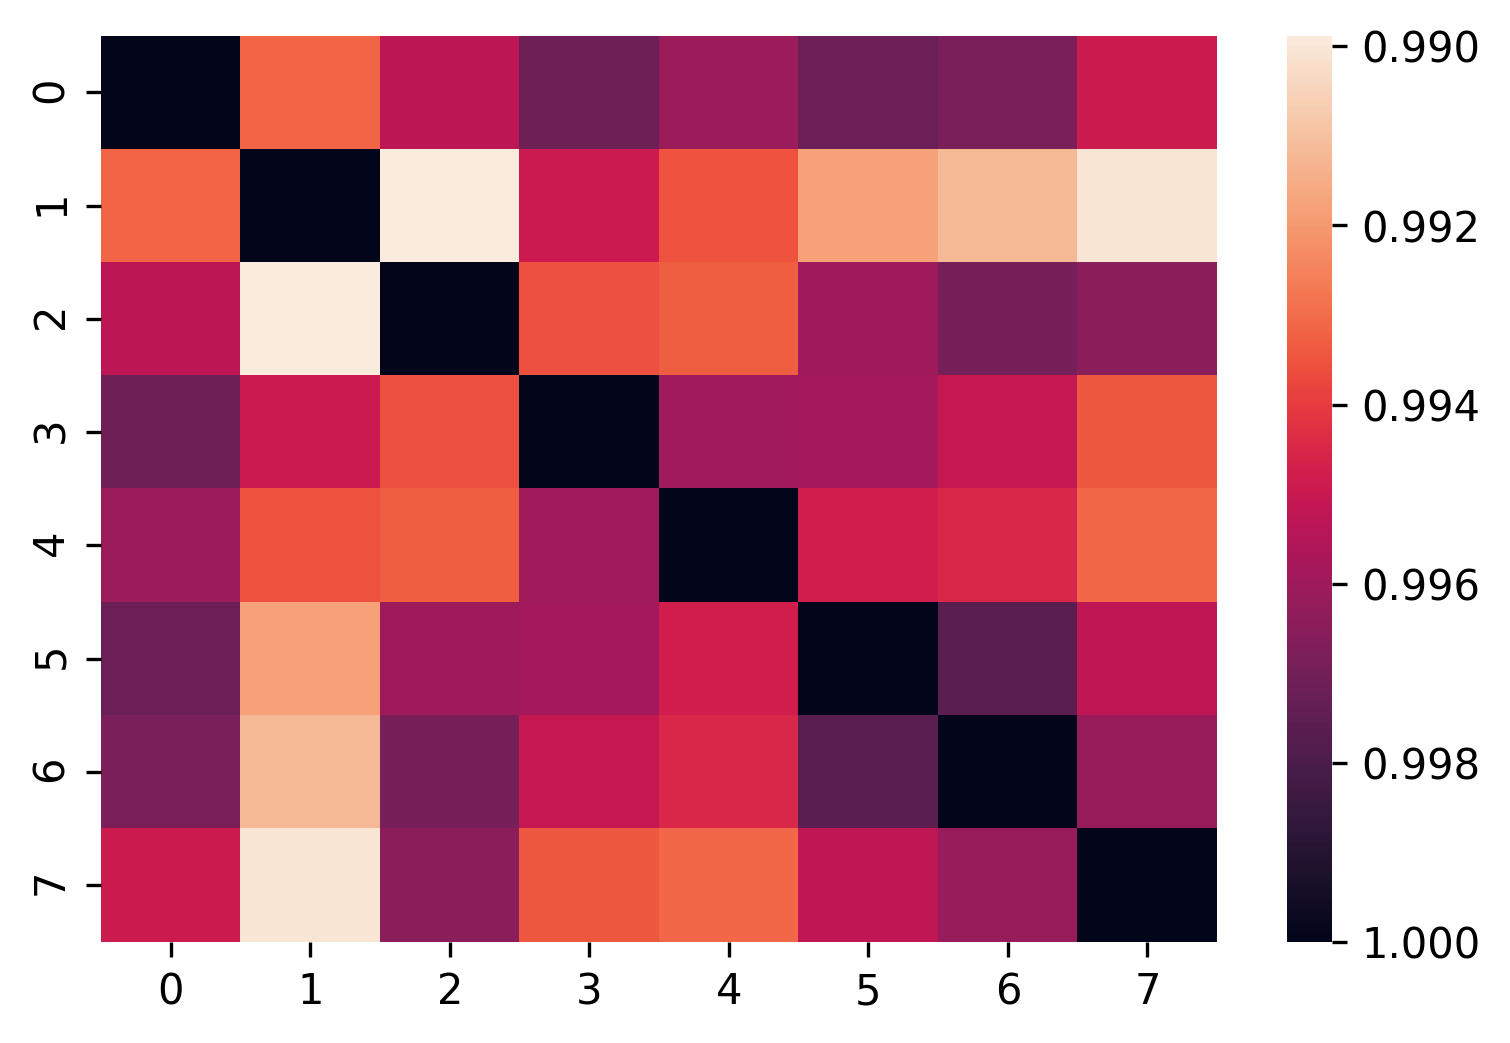

In [17]:
a=np.random.random((10,10))
b=seaborn.heatmap(all_to_all_by_groups[group_id][organelle_name][display_name(metric)].copy(),cmap="rocket_r")
plt.gcf().axes[1].invert_yaxis()

In [7]:
df = pandas.read_csv("MaskingInformationAmiraCoordinatesNewColumns.csv",header=[0,1])
print(df.shape)
def df_get(df, column, subcolumn=None):
    if subcolumn:
        return df[column][subcolumn]
    else:
        # Way to treat it when  contains eg unnamed 0_level_0
        return df[column][df[column].keys()[0]]
print(df_get(df, "original coordinates","x"))


(70, 70)
0     3450.0
1     6670.0
2     3840.0
3     7800.0
4     7068.0
       ...  
65       NaN
66       NaN
67       NaN
68       NaN
69       NaN
Name: x, Length: 70, dtype: float64


In [20]:
a=zarr.open("/groups/cosem/cosem/ackermand/annotation_and_analytics/n5s/group1/group1_01.n5",mode="r")["1b"]
print(a[1:3,1:3,1:3])

[[[4 4]
  [4 4]]

 [[4 4]
  [4 4]]]


In [73]:
a=np.random.random((2,3,4))
b=np.random.random((2,3,4))
a[b>0.5]=1
c=np.stack((a,b))
print(a)
print(b)
print(c)
print(np.var(c,axis=0).shape)

[[[0.24607862 1.         0.23882335 0.3075039 ]
  [0.54708079 0.06451196 0.74182371 1.        ]
  [1.         0.87201322 1.         0.70389306]]

 [[1.         1.         1.         1.        ]
  [1.         0.47092077 1.         1.        ]
  [0.34139064 0.010073   0.02635959 1.        ]]]
[[[0.44189268 0.98452095 0.34599206 0.41164648]
  [0.3059832  0.43125672 0.345327   0.53013013]
  [0.80911424 0.28171243 0.85383461 0.029224  ]]

 [[0.9069194  0.53428262 0.85601761 0.90305499]
  [0.58269879 0.05278758 0.59659958 0.70724134]
  [0.22252238 0.37224568 0.13555516 0.56271096]]]
[[[[0.24607862 1.         0.23882335 0.3075039 ]
   [0.54708079 0.06451196 0.74182371 1.        ]
   [1.         0.87201322 1.         0.70389306]]

  [[1.         1.         1.         1.        ]
   [1.         0.47092077 1.         1.        ]
   [0.34139064 0.010073   0.02635959 1.        ]]]


 [[[0.44189268 0.98452095 0.34599206 0.41164648]
   [0.3059832  0.43125672 0.345327   0.53013013]
   [0.80911424 0.2

In [64]:
np.var(np.asarray([0,0,1,1]),ddof=1)

0.3333333333333333

In [21]:
f=[1,2,3]
f[1:2]

[2]

In [3]:
a=1+5
b=a+2
print(b)

8


In [16]:
a=np.random.random((6,6))//0.5
b=np.zeros((8,8))
b[1:7,1:7] = 1
d = distance_transform_edt(b)
print(d)
d=d[1:-1,1:-1]
print(a)
print(d)
print(np.abs(distance(a))<=d)
print(distance(a))


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 2. 2. 2. 2. 1. 0.]
 [0. 1. 2. 3. 3. 2. 1. 0.]
 [0. 1. 2. 3. 3. 2. 1. 0.]
 [0. 1. 2. 2. 2. 2. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 2. 2. 2. 2. 1.]
 [1. 2. 3. 3. 2. 1.]
 [1. 2. 3. 3. 2. 1.]
 [1. 2. 2. 2. 2. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
[[ 0.  0.  0. -1.  0. -1.]
 [-1. -1. -1.  0.  0.  0.]
 [-1.  0.  0. -1. -1.  0.]
 [-1.  0. -1. -1.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.]
 [ 0.  0. -1. -1.  0.  0.]]


In [20]:
im = tifffile.imread("/groups/cosem/cosem/ackermand/annotation_and_analytics/group1-labels/group1_01/group1_01_1a/group1_01_1a.tif")
im[ (im==3) | (im==4) | (im==5)] = 1
im[im!=1] = 0
b = np.zeros((im.shape[0]+2,im.shape[1]+2, im.shape[2]+2))
d = distance_transform_edt(b)
d=d[1:-1,1:-1, 1:-1]
valid = np.abs(distance(im))<=d


In [30]:
#im = zarr.load('/groups/cosem/cosem/ackermand/annotation_and_analytics/n5s/group1/group1_01.n5')["1a"]
with h5py.File("/groups/cosem/cosem/annotations/bigcat/HeLa_Cell3_Crop33_Mito001/HeLa_Cell3_Crop33_712x712x712+3194-26+5394.h5", "r") as f:
    im = f['volumes']['labels']['gt'][:]
im[ (im==3) | (im==4) | (im==5)] = 1
im[im!=1] = 0
b = np.zeros((im.shape[0]+2,im.shape[1]+2, im.shape[2]+2))
b[1:-1,1:-1,1:-1] = 1
d = distance(b)
d=d[1:-1,1:-1,1:-1]
d_tanh = 128*np.tanh(4*d/50) + 127
im_edge = im.copy()
im_edge = np.pad(im_edge, 1, mode='edge')
im_edge[1:-1,1:-1,1:-1] = 0

im = np.pad(im, 1, mode='constant',constant_values=0) #- im_edge
im_d = distance(im)
im_d = im_d[1:-1,1:-1,1:-1]
im_tanh = 128*np.tanh(4*im_d/50)+127
valid = np.abs(im_d)<=np.abs(d)
for_visualization = distance(valid)==0

TypeError: Invalid shape (400, 400, 400) for image data

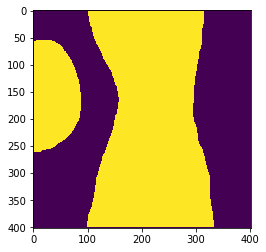

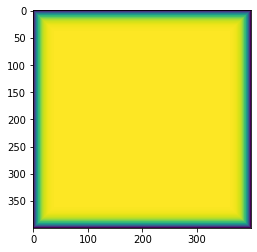

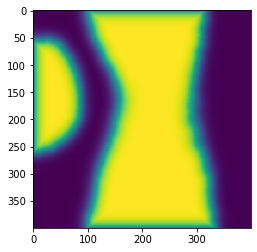

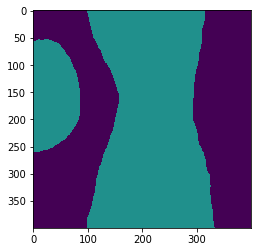

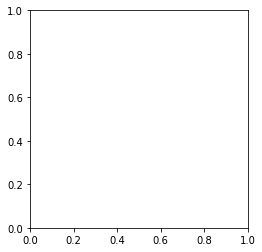

In [31]:
z=60
plt.imshow(im[:,:,z])
plt.figure()
plt.imshow(d_tanh[:,:,z])
plt.figure()
plt.imshow(np.round(im_tanh[:,:,z]))
plt.figure()
temp=im.copy()
temp = im[1:-1,1:-1,1:-1]
plt.imshow(temp[:,:,z],vmin=0,vmax=2)
plt.figure()
temp[for_visualization==1]=2
plt.imshow(temp,vmin=0,vmax=2)

In [121]:
print(np.tanh(120/50)*128)
np.amax(im_d[:,:,0])

125.91038178479107


30.0

In [35]:
a={}
a["b"]={}